In [192]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib
import matplotlib.pyplot as plt # this is used for the plot the graph 
from matplotlib import pyplot as plt, patches
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.cross_validation import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score
from scipy.signal import argrelextrema, resample

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

# time series
from datetime import datetime, timedelta

### Plotting params

In [239]:
sns.set(style="white") # set seaborn for pretty plots
#plt.rc('legend', fontsize=12) # legend fontsize

### Data munging functions
A bunch of helpers

In [2]:
# Renames columns to standard format listed above,
# Normalizes timestamps relative to 0 (instead of experiment start time),
# Fills NaNs, inverts force.
def clean(df):
    df.columns = ["f", "mdia", "msgtype", "pwm", "rc", "rw", "t", "t0", "timestamp"]
    if(df.iloc[0].timestamp > 0):
        df.timestamp -= df.iloc[0].timestamp
    df.pwm.replace(to_replace=0, value=np.NaN, inplace=True)
    df.f = -df.f
    return df.fillna(0)

In [75]:
# Grabs rolling average with default lag of 300-points.
# You can set #points in rolling window with `window` param, and
# select whether to add the rolling average column to the given 
# dataframe with `add_col` param.
def ma(df, window=500, add_col=True):
    m = df.f.rolling(window=window).mean()
    if add_col:
        df['f_ra'] = m
        return df.fillna(0)
    return m

In [132]:
# Grabs minima and maxima.
# This is its own function only because this is an expensive operation.
# Note this function operates on the rolling average, not the raw force, to prevent noisy points from interfering.
def get_extrema(df, order=2000, ra=False):
    col = 'f_ra' if ra else 'f'
    maxima = argrelextrema(df[col].values, np.greater, order=order)
    minima = argrelextrema(df[col].values, np.less, order=order)
    return minima, maxima

In [133]:
# Labels cycles based on local (force) minima and maxima.
# Points not belonging to a valid cycle, e.g. at start and end of experiment,
# are labeled with <cycle# = -1>.
def label_cycles(df, minima, maxima, ax=None, abs_min=None, abs_max=None, plot_boxes=True):
    # Plot line connecting all minima, and another line connecting all maxima.
    if not ax:
        fig, ax = plt.subplots(figsize=(25, 6), nrows=1, ncols=1)
    if abs_min and abs_max:
        ax.plot(df.f, alpha=0.3)
        ax.plot(df.f.iloc[abs_max[0].tolist()], '--')
        ax.plot(df.f.iloc[abs_min[0].tolist()], '--')

    # Label cycles.
    df['cycle'] = -1
    for i in range(minima[0].size-1):
        rng = list(range(minima[0][i], minima[0][i+1]))
        df.iloc[rng, df.columns.get_loc('cycle')] = i # I don't know why `iloc` succeeds while `loc` fails here. I spent 1.5 hours on this bug.
  
    # Draw bounding boxes around each cycle.
    if plot_boxes:
        for i in minima[0].tolist():
            ax.add_patch(
                patches.Rectangle((i, df.f.min()), df[df.cycle==i].shape[0], df.f.max()-df.f.min(), linewidth=1, edgecolor='black', facecolor='none', alpha=0.2, linestyle=':')
            )
    df.cycle = df.cycle.astype(np.int64) # Just to be safe
    return df

In [186]:
# Squashes periods down to a constant for all rows in a dataset.
# You can set the desired period with param `period`.
# If you don't, the function just chooses the shortest period.
def squash_periods(df, period=-1, plot_cycles=True):
    c_to_p = {} # maps cycles to their periods
    columns=["f", "pwm", "t", "t0", "f_ra", "cycle", "timestamp"]
    fig, ax = plt.subplots(figsize=(25, 12), nrows=1, ncols=1)
    df.cycle, X = df.cycle.astype(np.int64), pd.DataFrame(columns=columns)
        
    for c in range(df.cycle.max()):
        c_to_p[c] = df[df.cycle==c].shape[0]
    if period<0:
        period = int(min(c_to_p.values()))

    for c in range(df.cycle.max()):
        C = pd.DataFrame(resample(df[df.cycle==c], period), columns=columns)
        C.cycle = c
        X = pd.concat([X, C], ignore_index=True)
        if plot_cycles:
            ax.plot(C.f_ra, color=plt.cm.RdYlBu(c/df.cycle.max()))
    X.timestamp = df.timestamp.iloc[:X.timestamp.size,]
    
    if plot_cycles:
        cmap = plt.cm.ScalarMappable(
            norm=matplotlib.colors.Normalize(vmin=0, vmax=df.cycle.max()),
            cmap=plt.get_cmap('RdYlBu', df.cycle.max())
        )
        cmap.set_array([])
        plt.colorbar(cmap, orientation="horizontal", pad=0.1)
        
    return X, c_to_p

### Run data munging

In [187]:
# X_100 is a dataset with estimated 100 cycles and conductive paste in silicon skin.
df = ma(clean(pd.DataFrame.from_dict(
    pd.read_msgpack("data/data_2018-11-16-21-07-24.msgpack"))), window=150)

# clean up unnecessary columns
df.drop(columns=['mdia', 'msgtype', 'rc', 'rw'], inplace=True)

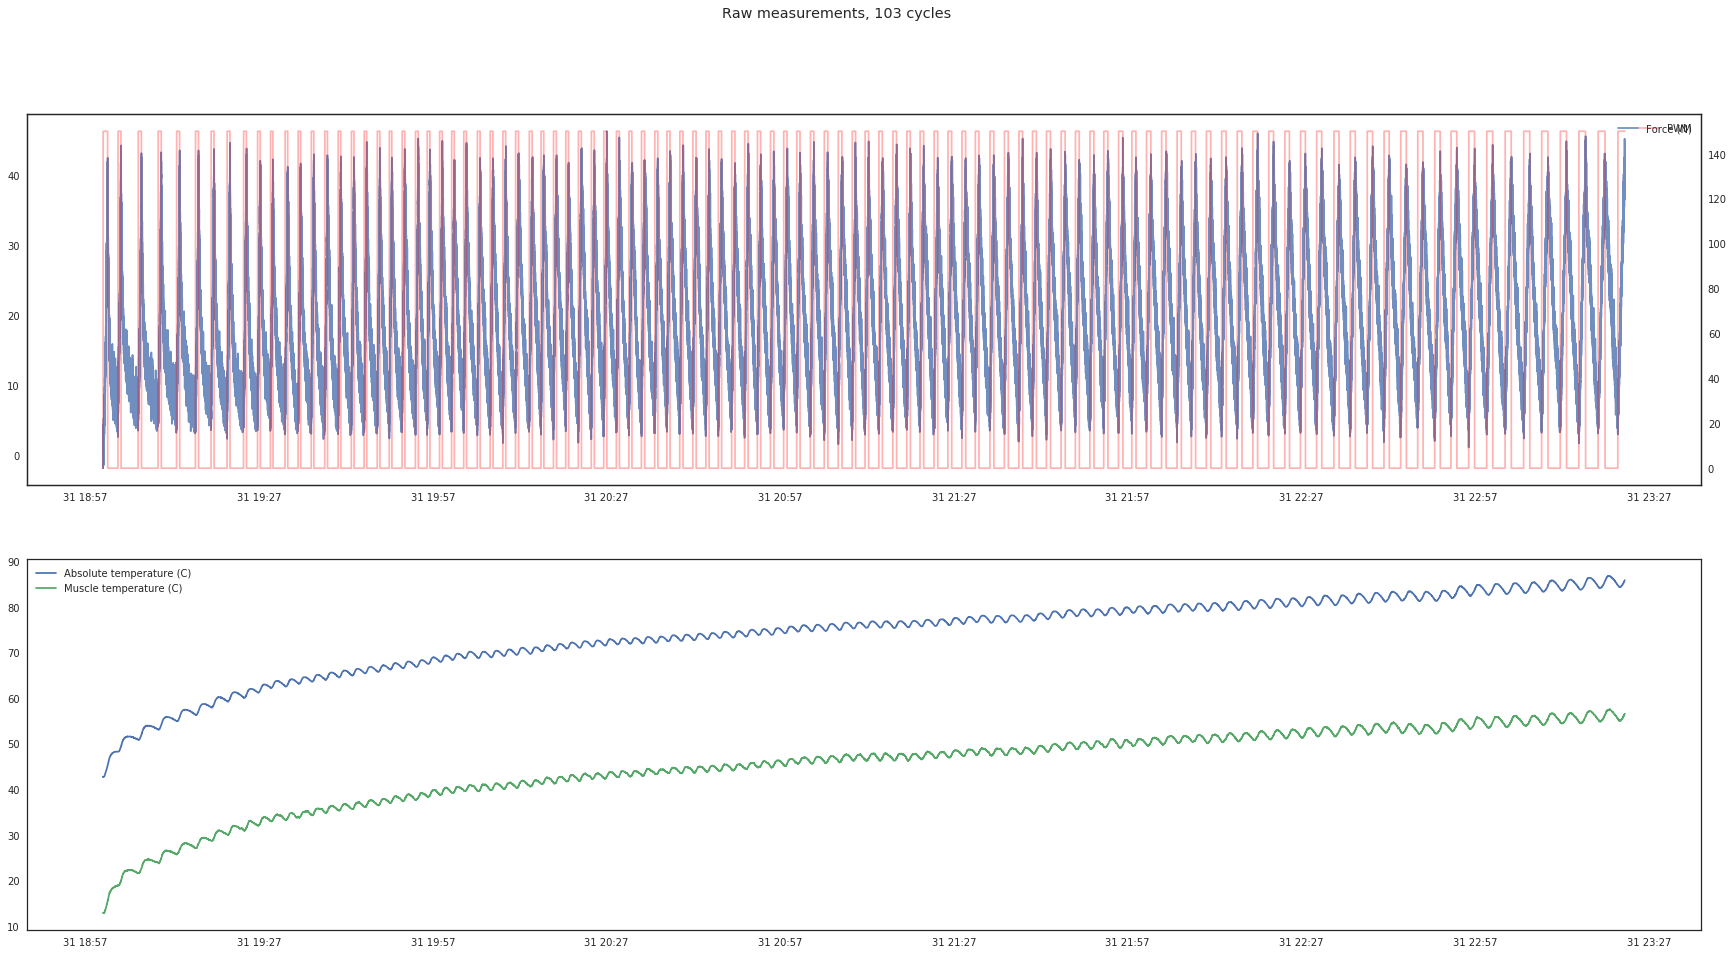

In [255]:
# one figure / two charts
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(30, 15))
fig.suptitle('Raw measurements, %d cycles' % 103)

# top chart
ax.flat[0].plot(df.f, alpha=0.8, label='Force (N)'); ax2 = ax.flat[0].twinx()
ax2.plot(df.pwm, c='r', alpha=0.3, label='PWM')
ax.flat[0].legend(); ax2.legend()

# bottom chart
ax.flat[1].plot(df.t, label='Absolute temperature (C)'); ax.flat[1].plot(df.t-df.t0, label='Muscle temperature (C)')
ax.flat[1].legend()
plt.show()

### Force-temperature correlation
Joint probabilities / Pearson correlation let us know whether a temperature-force relationship is worth investigating

In [193]:
minima, maxima = get_extrema(df, ra=True)
abs_min, abs_max = get_extrema(df, order=3000, ra=False)
df = label_cycles(df, minima, maxima, abs_min=abs_min, abs_max=abs_max)
df.cycle = df.cycle.astype(np.int64)
df_s, c_to_p = squash_periods(df)
df_s.cycle = df_s.cycle.astype(np.int64)

In [226]:
if type(df.timestamp.iloc[0,]) != pd._libs.tslibs.timestamps.Timestamp: # convert to datetime timestamp, if necessary
    df.timestamp = df.timestamp.map(lambda t: datetime.fromtimestamp(t))
    df.set_index(pd.DatetimeIndex(df.timestamp), inplace=True)
df_s.set_index(pd.DatetimeIndex(df_s.timestamp.map(lambda t: datetime.fromtimestamp(t))), inplace=True);

In [236]:
season = int((df_s[df_s.cycle==1].shape[0])/0.1) #ms

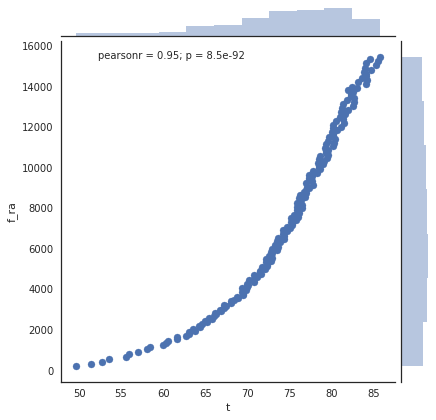

In [251]:
sns.jointplot(x=df_s.resample('%dL' % season).mean().t,\
              y=df_s.resample('%dL' % season).mean().f_ra, ratio=10)
plt.show()

### Train-test split

In [351]:
data = np.apply_along_axis(lambda row: np.reshape(row, (1,-1)), 1, df.drop(columns=['timestamp']).values)

In [352]:
cutoff = int(0.8 * data.shape[0])
train, test = data[:cutoff,], data[cutoff:,]

In [353]:
train_X, train_y = train[:,:,1:], train[:,:,0].flatten()
test_X, test_y = test[:,:,1:], test[:,:,0].flatten()

In [354]:
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((721220, 1, 5), (721220,), (180306, 1, 5), (180306,))

### LSTM
Time-series/sequential problem. Framing this as a supervised learning problem:

Given temperature $ T $ at current time $ t $, and force (N) $f$, $T$ at $0...(t-1)$,
predict $f$ at $t$

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(train_X, train_y, epochs=20, batch_size=70,\
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 721220 samples, validate on 180306 samples
Epoch 1/20
